# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

d:\Programs\anac\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [4]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [06:33<00:00, 433kB/s]  


Посмотрим на изображения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


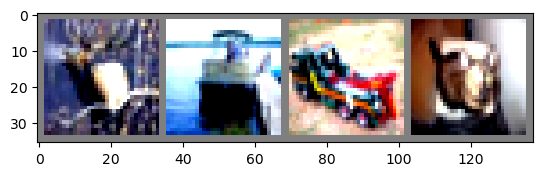

deer ship truck cat


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [158]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.first = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)            
        )
        self.second = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8, 8),
            nn.Flatten(),
            nn.Linear(512, 512), 
            nn.ReLU(), 
            nn.Linear(512, 10)
        )
        
        self.conv = nn.Conv2d(3, 32, 1)
      

    def forward(self, x):
        pred_1 = self.first(x)
        pred_2 = self.conv(x)

        out = pred_1 + pred_2

        out = self.second(out)

        return out

In [159]:
net = BasicBlockNet()
net

BasicBlockNet(
  (first): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (second): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
  (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
)

Проверим, что выход сети имеет корректную размерность:

In [160]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    ce = nn.CrossEntropyLoss()
    for data, target in loader:

        pred = model(data.to(device))
        loss = ce(pred, target.to(device))

        loss_log.append(loss.item())

        pred_classes = torch.argmax(pred.cpu(), dim=-1)

        acc = (pred_classes == target).sum() / len(target)
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    ce = nn.CrossEntropyLoss()
    for data, target in train_loader:

        pred = model(data.to(device))
        
        loss = ce(pred, target.to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        loss_log.append(loss.item())

        pred_classes = torch.argmax(pred.cpu(), dim=-1)

        acc = (pred_classes == target).sum() / len(target)

        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [162]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.597000947382158, train acc: 0.41896954162465155
 val loss: 1.4188017753844566, val acc: 0.48018617021276594

Epoch 1
 train loss: 1.3016157945723594, train acc: 0.5339065356489945
 val loss: 1.2150929689407348, val acc: 0.5694592198158832

Epoch 2
 train loss: 1.1457228821853833, train acc: 0.5938765016508712
 val loss: 1.1685473873260173, val acc: 0.5859042553191489

Epoch 3
 train loss: 1.0335525683990563, train acc: 0.6317372355862118
 val loss: 1.0519182737837447, val acc: 0.6305186170212767

Epoch 4
 train loss: 0.9655455225564444, train acc: 0.6603225385685072
 val loss: 1.008044484828381, val acc: 0.6519060284533399

Epoch 5
 train loss: 0.9094163851720541, train acc: 0.6805056803187243
 val loss: 0.9753716773175178, val acc: 0.6593528369639782

Epoch 6
 train loss: 0.8484154008533227, train acc: 0.7016151410134227
 val loss: 0.9623045467315836, val acc: 0.6703014183551708

Epoch 7
 train loss: 0.8046665708696167, train acc: 0.718745919315645
 val loss: 0.

Посчитайте точность на тестовой выборке:

In [163]:
test_loss_log, test_acc_log = test(net, test_loader)

In [164]:
test_acc_log

0.725218949044586

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [ ]:
# измененный код из 3го семинара (03_Image_Classification)

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train")

    plt.plot(np.repeat(val_history, int(len(train_history) / len(val_history))),  label="val")

    plt.xlabel("batch")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

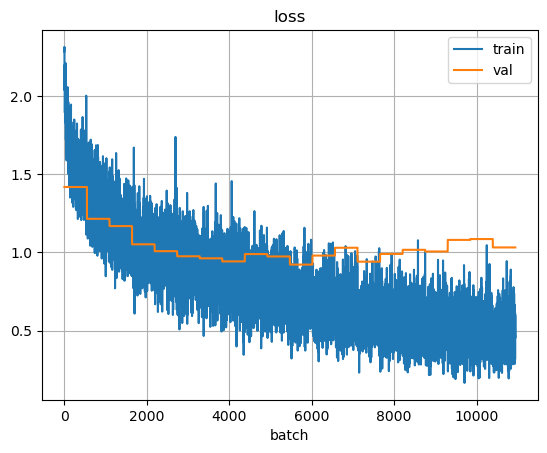

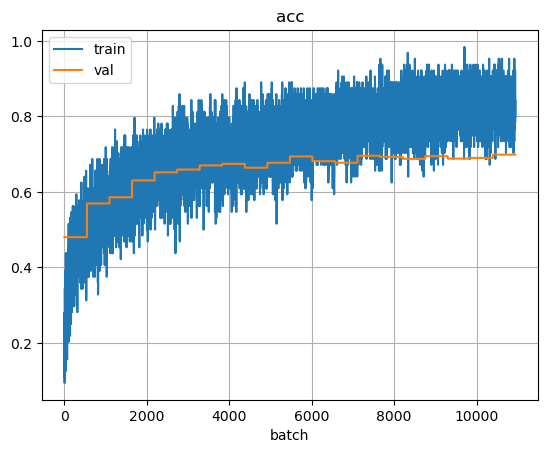

In [166]:
plot_history(train_loss_log, val_loss_log)
plot_history(train_acc_log, val_acc_log, 'acc')

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [167]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.6236972287978289, train acc: 0.4074170801931587
 val loss: 1.4859703987202746, val acc: 0.45729166662439386

Epoch 1
 train loss: 1.357977841410384, train acc: 0.5098793745258826
 val loss: 1.2920115404940666, val acc: 0.5408466312479465

Epoch 2
 train loss: 1.1908301283934, train acc: 0.573595423040268
 val loss: 1.1373842000961303, val acc: 0.5923315603682335

Epoch 3
 train loss: 1.085432463415798, train acc: 0.6168957299244687
 val loss: 1.0995853107026283, val acc: 0.616001773134191

Epoch 4
 train loss: 1.0111049931271638, train acc: 0.6405678702010968
 val loss: 1.035454247099288, val acc: 0.6388297872340426

Epoch 5
 train loss: 0.9513488798734256, train acc: 0.6649622943327239
 val loss: 0.9862420181010632, val acc: 0.6578900710065314

Epoch 6
 train loss: 0.8927059653036338, train acc: 0.6857861060329068
 val loss: 1.0199856709926687, val acc: 0.6467641843126175

Epoch 7
 train loss: 0.8490703139706112, train acc: 0.700484787197392
 val loss: 1.0466436

Посчитайте точность на тестовой выборке:

In [168]:
test_loss_log, test_acc_log = test(net, test_loader)

In [169]:
test_acc_log

0.7486066878980892

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [170]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.983196770469275, train acc: 0.2961608775137112
 val loss: 1.782426028556012, val acc: 0.37016843969517566

Epoch 1
 train loss: 1.6909891417083183, train acc: 0.39535045051705464
 val loss: 1.5932355474918447, val acc: 0.4317154255319149

Epoch 2
 train loss: 1.5472806092807971, train acc: 0.44213159439550676
 val loss: 1.4878682816282232, val acc: 0.4596409574468085

Epoch 3
 train loss: 1.456998103497451, train acc: 0.47471190256218154
 val loss: 1.4193445773834878, val acc: 0.4877659574468085

Epoch 4
 train loss: 1.4060995988479699, train acc: 0.49378509397262627
 val loss: 1.3728870401991176, val acc: 0.5060948581137555

Epoch 5
 train loss: 1.3628598401489815, train acc: 0.5098793745258826
 val loss: 1.3339247845588846, val acc: 0.513031914893617

Epoch 6
 train loss: 1.3238559943884338, train acc: 0.5249738834893681
 val loss: 1.2939161871341949, val acc: 0.5355939716734784

Epoch 7
 train loss: 1.2862350920000722, train acc: 0.5384932424076296
 val loss: 

In [171]:
test_loss_log, test_acc_log = test(net, test_loader)

In [172]:
test_acc_log

0.6687898089171974

Качество на тесте получилось хуже, как и ожидали.

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1./8., total_iters=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.6028608510873434, train acc: 0.4157294659335609
 val loss: 1.394718322855361, val acc: 0.4938608155605641

Epoch 1
 train loss: 1.3834376785175455, train acc: 0.5002938103632256
 val loss: 1.3723277893472225, val acc: 0.5120124113052449

Epoch 2
 train loss: 1.2560524763965084, train acc: 0.5494050339981232
 val loss: 1.2336551118404306, val acc: 0.5642730497299356

Epoch 3
 train loss: 1.1478276107821213, train acc: 0.5904201488172333
 val loss: 1.1284551650919812, val acc: 0.5917331561129144

Epoch 4
 train loss: 1.0748566453374064, train acc: 0.619637960271818
 val loss: 1.10227159616795, val acc: 0.611591311972192

Epoch 5
 train loss: 1.0052149980116152, train acc: 0.6433998759311558
 val loss: 1.043582086360201, val acc: 0.6350398936170213

Epoch 6
 train loss: 0.9608650188995236, train acc: 0.6634769195612431
 val loss: 1.0871800364331996, val acc: 0.6179521276595744

Epoch 7
 train loss: 0.920521811876698, train acc: 0.6756659702583466
 val loss: 1.070260

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5, eta_min = 0.0001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.6138278786399465, train acc: 0.40973491773308957
 val loss: 1.3619392486328774, val acc: 0.5065602836456705

Epoch 1
 train loss: 1.3214885050897407, train acc: 0.5245821363747228
 val loss: 1.2704098551831347, val acc: 0.5483820922831272

Epoch 2
 train loss: 1.134085738135866, train acc: 0.5985407417391511
 val loss: 1.1395957216303398, val acc: 0.5913120566530431

Epoch 3
 train loss: 0.9863945355798907, train acc: 0.6490271611231119
 val loss: 1.0029273738252356, val acc: 0.6429964539852548

Epoch 4
 train loss: 0.8587352839422836, train acc: 0.6960286628829496
 val loss: 0.9195716348100216, val acc: 0.6741799646235527

Epoch 5
 train loss: 0.8188735289155238, train acc: 0.7100948354661791
 val loss: 0.9130977907079332, val acc: 0.6762854609083622

Epoch 6
 train loss: 0.8245330602203035, train acc: 0.7096990075582125
 val loss: 0.9110330447237542, val acc: 0.6799867021276595

Epoch 7
 train loss: 0.8921319789489837, train acc: 0.6867899581980662
 val loss: 0

In [175]:
## вернуть 20
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=10, power=2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.6373246716406924, train acc: 0.4041525202324883
 val loss: 1.4482741021095438, val acc: 0.47548758869475505

Epoch 1
 train loss: 1.356792062793397, train acc: 0.5127644293704896
 val loss: 1.2721352490972966, val acc: 0.5466533688788718

Epoch 2
 train loss: 1.178714020923461, train acc: 0.579936830718513
 val loss: 1.122269492453717, val acc: 0.6000221630360217

Epoch 3
 train loss: 1.0465348749753545, train acc: 0.6275667602662849
 val loss: 1.0648694880465244, val acc: 0.6276595744680851

Epoch 4
 train loss: 0.9435592913758384, train acc: 0.6637788914021452
 val loss: 0.9867615735277216, val acc: 0.6525709220703612

Epoch 5
 train loss: 0.8618465256647393, train acc: 0.6933598850719236
 val loss: 0.9660174575257808, val acc: 0.6608820922831271

Epoch 6
 train loss: 0.7914483608776735, train acc: 0.7184765930585495
 val loss: 0.9189736150680704, val acc: 0.6797650710065314

Epoch 7
 train loss: 0.7296612832075499, train acc: 0.7434667993943042
 val loss: 0.88

- LinearLR - уменьшает длину шага линейно. Каждую итерацию мы умножаем длину шага на коэффициент (start_factor) в первой эпохе, в других этот коэффициент приближается к end_factor или 1, пока не дойдем до конца total_iters или до last_epoch. 
- CosineAnnealingLR - использует "косинувый отжиг". Длина шага сначала максимальная, далее уменьшается до минимума (eta_min), и снова увеличивается до макимума. Формулы расчета можно посмотреть в документации 
- PolynomialLR - Уменьшает скорость изменения шага по выбранной степени. Шаг рассчитывается по формуле: lr * (1 - current_step/total_iters) ** power

| Метод | Метрика на тестовой выборке |
|---|---|
| MultiStepLR | 0.7486066878980892 |
| LinearLR | 0.7243232484076433 |
| CosineAnnealingLR | 0.6941679936305732 |
| PolynomialLR | 0.7276074840764332 |

Лучше всего себя показал MultiStepLR.




## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


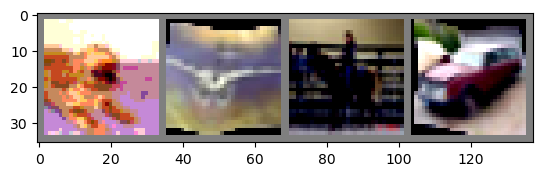

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


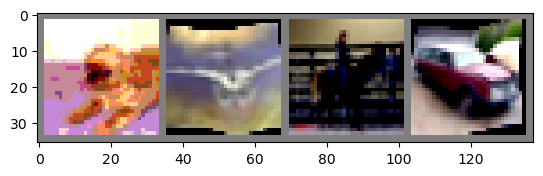

In [176]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.508199901423899, train acc: 0.4537534277879342
 val loss: 1.3622797372493338, val acc: 0.4987367021276596

Epoch 1
 train loss: 1.1831460259514273, train acc: 0.5807284865344464
 val loss: 1.135768611887668, val acc: 0.5990026595744681

Epoch 2
 train loss: 1.0239259128814642, train acc: 0.6406739684301931
 val loss: 0.9435820356328437, val acc: 0.6717420212765958

Epoch 3
 train loss: 0.9265087349323293, train acc: 0.6754945808616373
 val loss: 1.003653927813185, val acc: 0.6539450353764473

Epoch 4
 train loss: 0.8526803069838222, train acc: 0.6998196330323297
 val loss: 0.9034310881127703, val acc: 0.6897606382978724

Epoch 5
 train loss: 0.791357855147374, train acc: 0.7207413815928987
 val loss: 0.8668549070967004, val acc: 0.7036790779296388

Epoch 6
 train loss: 0.7438237436619711, train acc: 0.7413938038963722
 val loss: 0.8396691471972364, val acc: 0.7090425531914893

Epoch 7
 train loss: 0.7070335865129719, train acc: 0.7530033951267682
 val loss: 0.862

Посчитайте точность на тестовой выборке:

In [178]:
test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

0.7684116242038217


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomPerspective(distortion_scale = 0.4, p = 0.5, fill = 1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.6478929837835337, train acc: 0.3995698942126914
 val loss: 1.4810066055744253, val acc: 0.4518617021276596

Epoch 1
 train loss: 1.3728114316406808, train acc: 0.5045867067586352
 val loss: 1.408909560264425, val acc: 0.5062056736743197

Epoch 2
 train loss: 1.2258325235499326, train acc: 0.5596761556386511
 val loss: 1.176543324298047, val acc: 0.5835106382978723

Epoch 3
 train loss: 1.1178005016264139, train acc: 0.6040904936014625
 val loss: 1.1479888905870153, val acc: 0.5975398936170213

Epoch 4
 train loss: 1.0239079819082997, train acc: 0.6376052820268453
 val loss: 1.0352228327000395, val acc: 0.6408244680851064

Epoch 5
 train loss: 0.9675616050986965, train acc: 0.6568825084722892
 val loss: 1.0149102330207824, val acc: 0.6461657800572984

Epoch 6
 train loss: 0.9141164170322732, train acc: 0.6783755550218893
 val loss: 0.9682534397916591, val acc: 0.6615248226104898

Epoch 7
 train loss: 0.8737295377298072, train acc: 0.6941311373571155
 val loss: 0.9

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomPosterize(3, p = 0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.495914384913401, train acc: 0.4605192282735974
 val loss: 1.3515416472516162, val acc: 0.508798758907521

Epoch 1
 train loss: 1.1718696835272056, train acc: 0.5853519195612431
 val loss: 1.1468964508239259, val acc: 0.6044769502700643

Epoch 2
 train loss: 0.9970105015817464, train acc: 0.6503737920816899
 val loss: 0.9948576749639308, val acc: 0.6578679077168729

Epoch 3
 train loss: 0.8965045192995716, train acc: 0.6852433729433273
 val loss: 1.0550646206165881, val acc: 0.6391400710065314

Epoch 4
 train loss: 0.8091552763686973, train acc: 0.7139919038446555
 val loss: 0.9673087533484114, val acc: 0.6694592199427016

Epoch 5
 train loss: 0.7237654960351627, train acc: 0.7440380973833353
 val loss: 0.9271919942916708, val acc: 0.6850842199427016

Epoch 6
 train loss: 0.6654898788527989, train acc: 0.7671552625173189
 val loss: 0.9957340813697653, val acc: 0.6681515957446809

Epoch 7
 train loss: 0.6104475428678872, train acc: 0.784918549182864
 val loss: 0.90

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        transforms.RandomErasing(p=0.5, scale=(0.01, 0.22), ratio=(0.2, 3), value = 'random')
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.5579698958606127, train acc: 0.43590852705390626
 val loss: 1.4148346931376357, val acc: 0.4750886525245423

Epoch 1
 train loss: 1.249313939424058, train acc: 0.5578888091352348
 val loss: 1.1929379016795056, val acc: 0.5878324468085107

Epoch 2
 train loss: 1.0859767887230547, train acc: 0.616540709077985
 val loss: 1.0560016791871254, val acc: 0.6334219859001484

Epoch 3
 train loss: 0.982203748478968, train acc: 0.6556501371115173
 val loss: 1.0629612225167295, val acc: 0.6300975178150421

Epoch 4
 train loss: 0.8911463911398237, train acc: 0.6867409897678731
 val loss: 1.0033812383387952, val acc: 0.6546985816448293

Epoch 5
 train loss: 0.8167077377029921, train acc: 0.7123147362546903
 val loss: 0.9074490805889698, val acc: 0.6874778369639782

Epoch 6
 train loss: 0.7534375878857956, train acc: 0.7365867393108347
 val loss: 0.9561193666559584, val acc: 0.6741578013338941

Epoch 7
 train loss: 0.7106554796425473, train acc: 0.7499795964692585
 val loss: 0.9

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomChoice([
            transforms.RandomPerspective(distortion_scale = 0.4, p = 0.5, fill = 1),
            transforms.RandomPosterize(3, p = 0.5),
            transforms.ElasticTransform(alpha = 50., sigma = 5.)
        ],p = [0.3, 0.3, 0.3]), 
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

test_loss_log, test_acc_log = test(net, test_loader)
print(test_acc_log)

Epoch 0
 train loss: 1.6188317441417268, train acc: 0.4117262992715051
 val loss: 1.4946248470468724, val acc: 0.45283687939035133

Epoch 1
 train loss: 1.364722389189809, train acc: 0.5084960171901766
 val loss: 1.2977772334788709, val acc: 0.5384086880278081

Epoch 2
 train loss: 1.219868069375019, train acc: 0.5652871180931872
 val loss: 1.173874541546436, val acc: 0.5848182624958931

Epoch 3
 train loss: 1.1065250388882932, train acc: 0.607008194029876
 val loss: 1.1506544399768748, val acc: 0.5935062055892133

Epoch 4
 train loss: 1.0272059710849573, train acc: 0.6340836380255942
 val loss: 1.0465185140041595, val acc: 0.6348182624958931

Epoch 5
 train loss: 0.9504047191992974, train acc: 0.6677086053644281
 val loss: 0.9838389954668411, val acc: 0.6530806736743197

Epoch 6
 train loss: 0.8966058738379853, train acc: 0.6854678114545847
 val loss: 1.0377790983687056, val acc: 0.6361037234042554

Epoch 7
 train loss: 0.8516763934705549, train acc: 0.697550763922592
 val loss: 1.007

Your answers here:
- RandomPerspective - меняет случайно перспективу изображения. Параметры: distortion_scale - степень искажения, p - вероятность трансформации, fill - каким пискелем заполнять пустую область.
- RandomPosterize - уменьшает кол-во бит каждого цветного канала. Параметры: bits - кол-во бит для сохранения в каждом цветовом канале, p - вероятность трансформации.
- RandomErasing - случайно выбирает участок и удаляет его на фотографии, работает только с тензорами. Параметры: p - вероятность трансформации, scale - диапазон какую часть изображения можно удалять в сравнении с входным, ratio - диапазон соотношения сторон удаляемой области, value - позволяет выбрать удалять все пиксели или из цветового канала определенного или рандомно.
- ElasticTransform - Создает эффект воды на картинке. Параметры: alpha - управляет силой смещения, sigma - управляет плавностью изменений.

| Метод | Метрика на тестовой выборке |
|---|---|
| RandomHorizontalFlip | 0.7684116242038217 |
| RandomPerspective | 0.7499004777070064 |
| RandomPosterize | 0.7375597133757962 |
| RandomErasing | 0.7563694267515924 |
| Все вместе (+ ElasticTransform) | 0.7551751592356688 |

Лучшее качество получилось и исходных трансформаций - RandomHorizontalFlip. Далее RandomErasing и у всех вместе.

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [185]:
import wandb

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    ce = nn.CrossEntropyLoss()
    for data, target in loader:

        # <your code here>
        pred = model(data.to(device))
        loss = ce(pred, target.to(device))

        loss_log.append(loss.item())

        # <your code here>
        pred_classes = torch.argmax(pred.cpu(), dim=-1)

        acc = (pred_classes == target).sum() / len(target)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    ce = nn.CrossEntropyLoss()
    for data, target in train_loader:

        # <your code here>
        pred = model(data.to(device))
        
        loss = ce(pred, target.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        loss_log.append(loss.item())

        # <your code here>

        pred_classes = torch.argmax(pred.cpu(), dim=-1)

    
        acc = (pred_classes == target).sum() / len(target)

        acc_log.append(acc.item())

        wandb.log(
            {
                "train loss": loss.item(),
                "train accuracy": acc.item(),
            }
        )

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        wandb.log(
                {
                    "mean val loss": val_loss,
                    "mean val accuracy": val_acc
                }
            )

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label="train")

    plt.plot(np.repeat(val_history, int(len(train_history) / len(val_history))),  label="val")

    plt.xlabel("batch")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

In [ ]:
!wandb login 

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\DARYA\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


mean val accuracy,▁▃▄▅▆▇▆▇█▇█▇▇███████
mean val loss,█▅▄▄▃▂▃▁▁▂▁▂▂▂▂▂▃▃▂▃
train accuracy,▁▂▂▄▄▆▅▃▄▅▅▇▆▅▄▆▄▆▇▅▇▇▆▇▅▆▆▅▆▇▆█▇▇▇█▇█▇▇
train loss,▇▆█▆▄▄▄▅▄▄▄▄▄▃▅▃▂▄▄▃▂▃▁▂▃▂▂▂▂▁▃▁▁▂▂▁▂▂▂▁
mean val accuracy,0.69468
mean val loss,1.05991
train accuracy,0.89286
train loss,0.31846


Epoch 0
 train loss: 1.6345226954280567, train acc: 0.40245902979613657
 val loss: 1.4302302659826076, val acc: 0.4862145389648194

Epoch 1
 train loss: 1.3554941654423256, train acc: 0.5147068425331952
 val loss: 1.244580906249107, val acc: 0.5500664893617021

Epoch 2
 train loss: 1.1829582587892438, train acc: 0.5781739684301931
 val loss: 1.1374637187795436, val acc: 0.5935726949509154

Epoch 3
 train loss: 1.0688863763861507, train acc: 0.622380190619167
 val loss: 1.1462085711195114, val acc: 0.6013297872340425

Epoch 4
 train loss: 0.9958054071370601, train acc: 0.6478315160305016
 val loss: 1.042030344364491, val acc: 0.6372118795171697

Epoch 5
 train loss: 0.9269804653781424, train acc: 0.6763841734289905
 val loss: 1.0352514586550123, val acc: 0.644658688027808

Epoch 6
 train loss: 0.8747588597660308, train acc: 0.6922132084095064
 val loss: 1.016596083438143, val acc: 0.6440159574468085

Epoch 7
 train loss: 0.8263989140499226, train acc: 0.7094827305246315
 val loss: 0.928

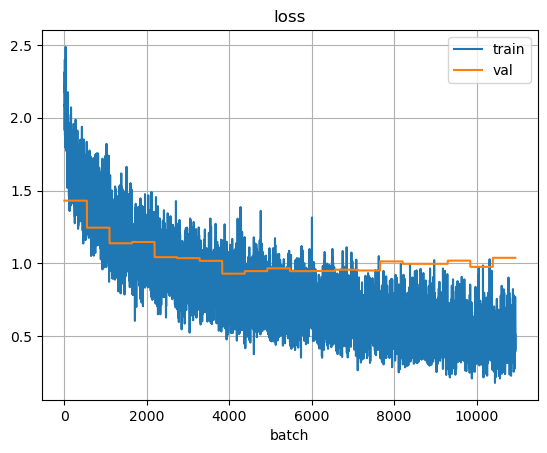

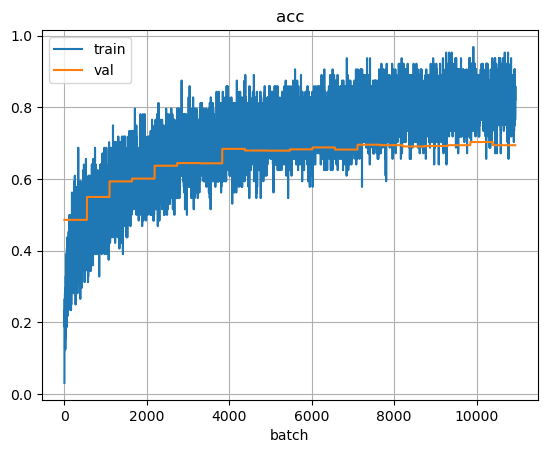

In [186]:
import wandb

wandb.init(project="pytorch-demo")

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

wandb.watch(net)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

test_loss_log, test_acc_log = test(net, test_loader)

print(test_acc_log)

plot_history(train_loss_log, val_loss_log)
plot_history(train_acc_log, val_acc_log, 'acc')

На всякий случай прикладываю графики с wandb:


https://api.wandb.ai/links/gorodbs-hse-university/l063c3qb

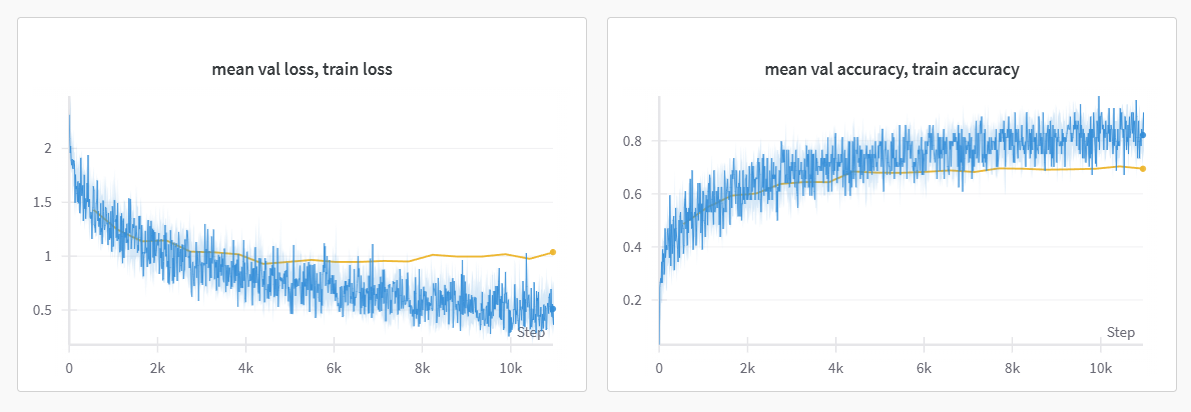